# Install Requirements

In [1]:
!pip install open3d azure-core azure-cognitiveservices-vision-computervision datashader

     |████████████████████████████████| 188.4MB 84kB/s 
     |████████████████████████████████| 143kB 41.0MB/s 
     |████████████████████████████████| 15.8MB 327kB/s 
     |████████████████████████████████| 92kB 9.0MB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 112kB 53.9MB/s 
     |████████████████████████████████| 706kB 50.2MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp37-none-any.whl size=59430 sha256=00686bb5f0b8071d70f0765b090aa367ac48fdb7ef56cb2a0b96a3f01a510f34
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
Successfully built datashape
ERROR: distributed 2021.4.1 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.4.1 has requirement dask>=2021.03.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: d

In [9]:
import open3d as o3d
import numpy as np

In [10]:
import PIL
from PIL import Image

# Extract objects from Pointcloud

## Generate CubeMaps from Panaoramas

In [ ]:
!python pano-conversion.py

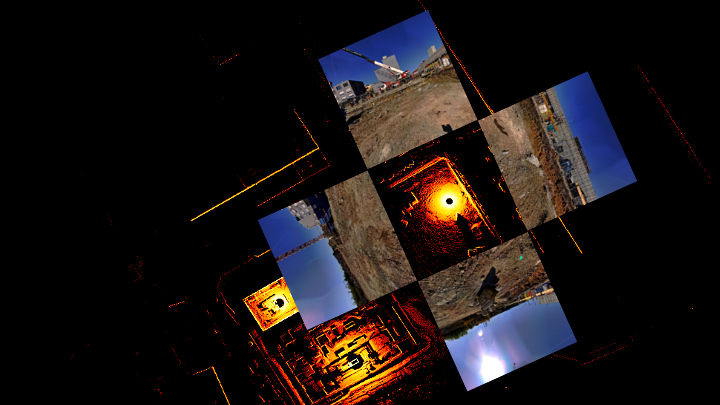

## Split images into smaller subcategories

In [ ]:
!python split-images.py

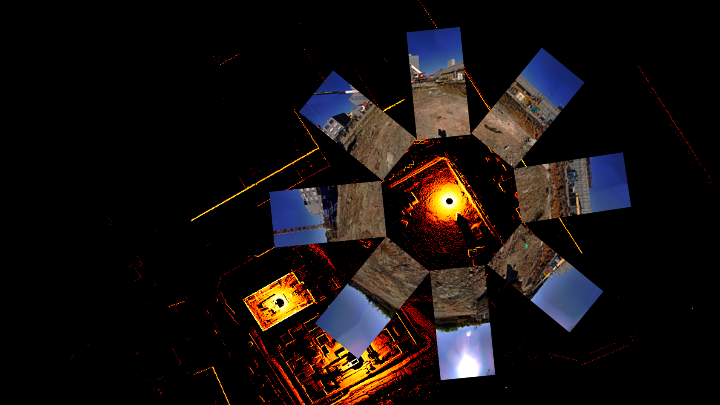

# Image classification

## Get image labels from Azure machine learning

In [ ]:
!python classification.py

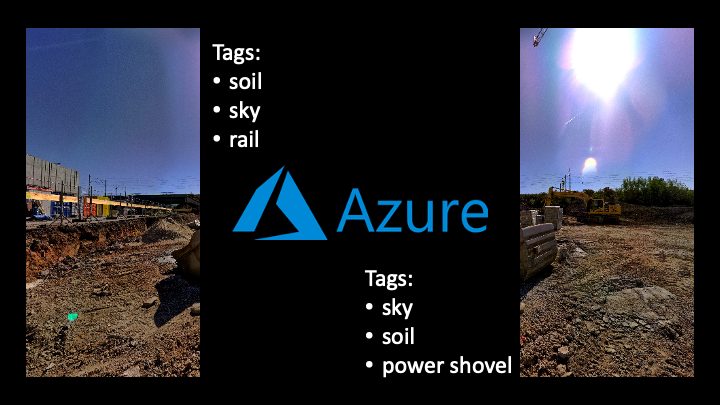

# Load the point clouds

In [16]:
print("Load a ply point cloud, print it, and render it")
pcd1 = o3d.io.read_point_cloud("scans/Scan_005.ply")
center1 = [3.42, -19.668]
rotation1 = 0.773 * np.pi #-0.608

pcd2 = o3d.io.read_point_cloud("scans/Scan_010.ply")
center2 = [29.97, 28.63]
rotation2 = 0.96 * np.pi

pcd3 = o3d.io.read_point_cloud("scans/Scan_009.ply")
center3 = [-17.6, -1.865]
rotation3 = 0.608 * np.pi

Load a ply point cloud, print it, and render it


In [17]:
points = np.concatenate([np.asarray(pcd1.points), np.asarray(pcd2.points), np.asarray(pcd3.points)])
colors = np.concatenate([np.asarray(pcd1.colors), np.asarray(pcd2.colors), np.asarray(pcd3.colors),])
centers = np.array([center1, center2, center3])
print(colors.shape)

(494655, 3)


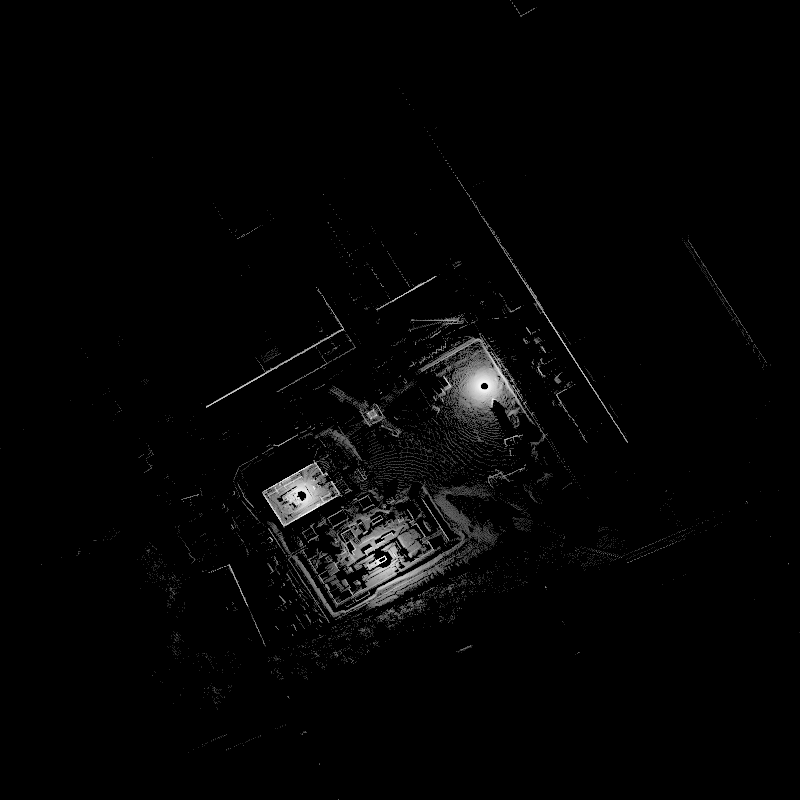

In [20]:
import datashader as ds, pandas as pd, colorcet as cc
from matplotlib import pyplot as plt
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9
from functools import partial
import datashader.transfer_functions as tf

plot_width  = 800
plot_height = 800


background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

cvs = ds.Canvas(plot_width, plot_height)
agg = cvs.points(df, 'x', 'y')

export(tf.shade(agg, cmap = cm(Greys9, 0.2), how='log'),"census_gray_log")

In [21]:
background="black"

if background == "black":
      color_key = {'w':'white', 'b':'lime',  'a':'aqua', 'c':'fuchsia', 'x':'orange' }
else: color_key = {'w':'blue', 'b':'green', 'a':'red', 'h':'orange',  'x':'saddlebrown'}

In [22]:
def create_image(w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h)
    agg = cvs.points(df, 'x', 'y', ds.count_cat('fence'))
    img = tf.shade(agg, color_key=color_key, how='log')
    return img

# Pull all labels from Azure and tag the point clouds accordingly

In [23]:
import math
from tqdm import tqdm

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1,v2):
  x1 = v1[0]
  y1 = v1[1]
  x2 = v2[0]
  y2 = v2[1]

  dot = x1*x2 + y1*y2
  det = x1*y2 - y1*x2
  angle = np.arctan2(det, dot) 
  return angle

fileName = "front_01_01.png"
scanAngles = {"Scan_009": 1.2834,
              "Scan_005": 1.905,
              "Scan_010": -0.514}

def getAngleRange(fileName, scanAngle): #(lowerAngle, upperAngle)
  direction, _, side = fileName.split(".")[0].split("_")
  directionAngles = {"front": 0, "left": np.pi/2, "back": np.pi, "right": 3*np.pi/2}
  sideAngles = {"01": np.pi/4, "02": -np.pi/4}
  bound1 = scanAngle + directionAngles[direction]
  bound2 = bound1 + sideAngles[side]
  lowerAngle = min(bound1, bound2) % (2*np.pi)
  upperAngle = max(bound1, bound2) % (2*np.pi)
  return (lowerAngle, upperAngle)

def isBetween(lower, upper, x):  
  if (upper - lower) < 0:  
    upper = upper - lower + 2*np.pi  
  else:
    upper = upper - lower

  if (x - lower) < 0:
    x = x - lower + 2*np.pi
  else:
    x = x - lower
  
  return (x < upper)

def compute_subcloud(cloud, center, range, label):
  print("Computing")

  array = df.values

  labels = []
  zero = [1,0]
  for row in array:
    point = np.array([row[0], row[1]])

    angle_vec = angle(zero, point - center)
    if isBetween(range[0], range[1], angle_vec):
      if row[5] == label:
        labels.append('c')
      else:
        labels.append(label)
    elif row[5] == label:
      labels.append(label)
    else:
      labels.append('a')

  return np.array(labels)

In [24]:
import pandas as pd

df = pd.DataFrame(
    {'x':points[...,0].ravel(), 
     'y':points[...,1].ravel(), 
     'z':points[...,2].ravel(), 
     'opacity':np.abs(points[...,2].ravel()) / np.max(np.abs(points[...,2].ravel())),
     'color':['rgb({},{},{})'.format(int(r),int(g),int(b)) for r,g,b in colors*255],
     'fence':['a'] * len(points)
    })

#df['label'] = df.label.astype('category')
df

,x,y,z,opacity,color,fence
0,2.81274,-20.076800,40.4531,0.476951,"rgb(87,94,104)",a
1,-21.70590,0.295340,82.5576,0.973373,"rgb(63,69,85)",a
2,-21.41030,0.573214,82.5346,0.973102,"rgb(62,68,84)",a
3,-20.92510,0.952126,82.4334,0.971909,"rgb(64,67,84)",a
4,-20.11090,1.837250,82.5595,0.973395,"rgb(64,70,86)",a
...,...,...,...,...,...,...
494650,-17.91180,-3.304140,32.1253,0.378765,"rgb(64,49,28)",a
494651,-17.93690,-3.298820,32.1253,0.378765,"rgb(81,65,40)",a
494652,-17.94460,-3.294510,32.1292,0.378811,"rgb(103,87,62)",a
494653,-17.95730,-3.240230,32.2085,0.379746,"rgb(72,55,29)",a


In [25]:
import json

scans = {'Scan_009':[-17.6, -1.865], 'Scan_005':[3.42, -19.668]} #, 'Scan_010':[29.97, 28.63]}
angles = ['front_01_01', 
          'front_01_02', 
          'left_01_01', 
          'left_01_02', 
          'right_01_01', 
          'right_01_01',
          'back_01_01',
          'back_01_02'
          ]

with open("recognitions/flattened_new.json") as json_file:
  data = json.load(json_file)

def compute_scans():
  for entry in tqdm(data):
    if entry['filename'].startswith("2019-09-21-BA1-pano.jpg/"):
      scan_location = entry['filename'][24:32]
      scan_rotation = entry['filename'][entry['filename'].rfind('/') + 1:-4]
      if scan_location in scans:
        if scan_rotation in angles:
          for tag in entry['tags']:
            if tag['name'] == 'crane' and tag['confidence'] > 0.1:
              location = np.array(scans[scan_location])
              range = getAngleRange(scan_rotation, scanAngles[scan_location])
              subcloud = compute_subcloud(df, location, range, 'x')
              df['fence'] = subcloud.tolist()
              df['fence'] = df.fence.astype('category')

compute_scans()

  0%|          | 0/21 [00:00<?, ?it/s]

Computing


 24%|██▍       | 5/21 [00:04<00:13,  1.17it/s]

Computing


100%|██████████| 21/21 [00:08<00:00,  2.53it/s]


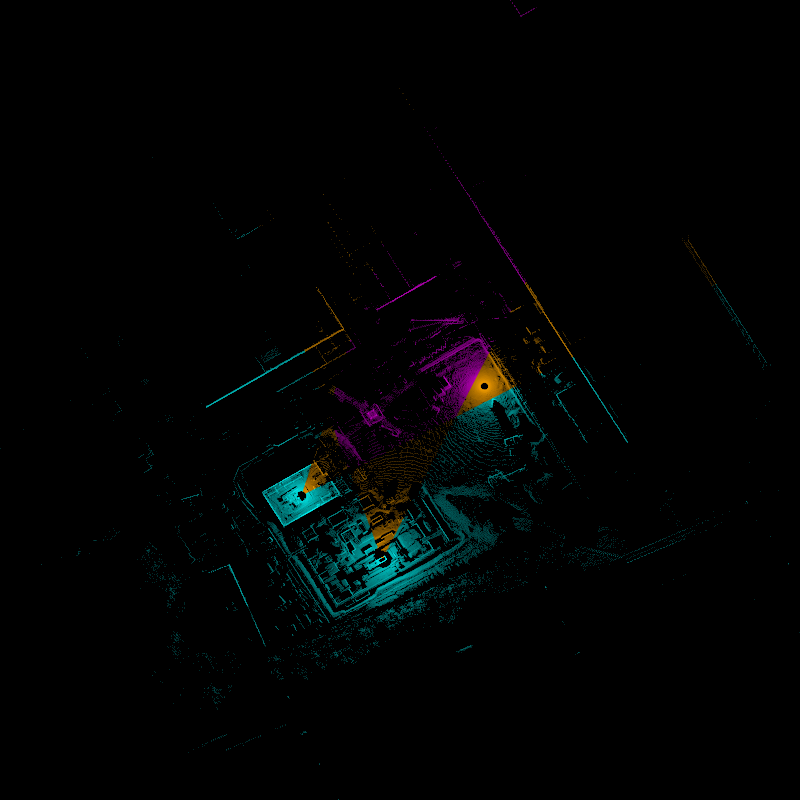

In [26]:
export(create_image(), "Peter")

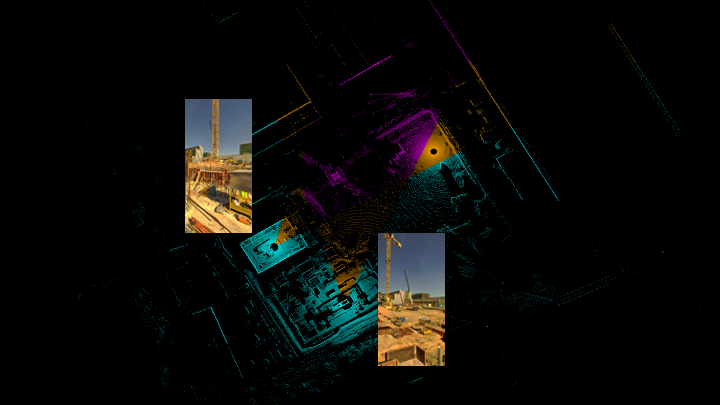

In [27]:
recogs = {}

for entry in tqdm(data):
  if entry['filename'].startswith("2019-09-21-BA1-pano.jpg/"):
    scan_location = entry['filename'][24:32]
    scan_rotation = entry['filename'][entry['filename'].rfind('/') + 1:-4]
    if scan_location in scans:
      if scan_rotation in angles:
        for tag in entry['tags']:
          if not tag['name'] in recogs:
            recogs[tag['name']] = 1
          else:
            recogs[tag['name']] += 1

100%|██████████| 21/21 [00:00<00:00, 133657.64it/s]


In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import copy 

for key in copy.copy(recogs):
  if recogs[key] < 2 or recogs[key] > 6:
    del recogs[key]

#plt.bar(range(len(recogs)), list(recogs.values()), align='center')
#plt.xticks(range(len(recogs)), list(recogs.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

#plt.show()

fig = go.Figure(data=[
    go.Bar(name='SF Zoo', x=list(recogs.keys()), y=list(recogs.values()))
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

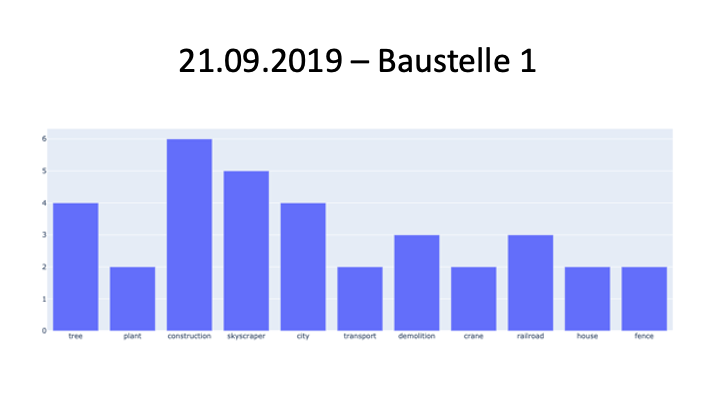